In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

df = pd.read_csv('subreddit_data.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,8,19,27,79,80,81,82,83,84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.shape

(19500, 85)

In [4]:
df = df[['subreddit', 'selftext', 'title']]

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# drop all missing values
df.dropna()

,subreddit,selftext,title
0,cars,[removed],Looking for an inexpensive bluetooth stereo co...
1,cars,I personally Think it’s Brooks From Dragtimes ...,Who produces the most underrated Car content o...
3,cars,I'm considering doing it and would love to hea...,Anyone have any direct experience selling a ca...
4,cars,"I apologize for the rant, but I seriously need...",Can any former or current car dealership mecha...
6,cars,[removed],Automotive News: Toyota axing Avalon sedan aft...
...,...,...,...
19489,travel,[removed],Anti-Asian racism
19490,travel,[removed],Book The Best Travel journey in UK from Luftha...
19493,travel,[removed],Global Entry Question
19495,travel,"Hey guys, in July me and a couple of friends p...",First Time Las Vegas Trip With My Boys.


In [7]:
df = (df[~df['subreddit'].isna()])
df = (df[~df['selftext'].isna()])
df = (df[~df['title'].isna()])

In [8]:
# remove 'removed', 'deleted'
df = df[df['selftext']!= '[removed]']
df = df[df['selftext']!='deleted']
df = df[~df['selftext'].str.startswith('[removed]')]

In [9]:
from bs4 import BeautifulSoup
import re
import string

In [10]:
# remove URL by using regex from colums selftext, title
df['selftext'] = df['selftext'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)
df['title'] = df['title'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)

In [11]:
# Remove certain reddit markdown issues from title and selftext column
for column in ['title','selftext','subreddit']:
    df[column] = df[column].str.replace('\xa0',' ', regex=True).replace('&lt;',' ', regex=True).replace('&gt;',' ', regex=True).replace('&amp;',' ', regex=True).replace('x200B','', regex=True).replace('\n',' ', regex=True)

In [12]:
# Remove punctuation manually:
string.punctuation += '’'
df['selftext'] = ["".join(l for l in s if l not in string.punctuation) for s in df['selftext']]
df['title'] = ["".join(l for l in s if l not in string.punctuation) for s in df['title']]
df['subreddit'] = [''.join(l for l in s if l not in string.punctuation) for s in df['subreddit']]

In [13]:
df['subreddit'].value_counts()

cars      2585
travel    2372
Name: subreddit, dtype: int64

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
# remove multiple consective blanks or spaces 
import re
df['selftext'] = [re.sub(' +', ' ', text) for text in df['selftext']]
df['title'] = [re.sub(' +', ' ', text) for text in df['title']]

In [16]:
df.head()

,subreddit,selftext,title
1,cars,I personally Think its Brooks From Dragtimes o...,Who produces the most underrated Car content o...
3,cars,Im considering doing it and would love to hear...,Anyone have any direct experience selling a ca...
4,cars,I apologize for the rant but I seriously need ...,Can any former or current car dealership mecha...
11,cars,Surely whichever car manufacturer makes one co...,Isnt there a market for a small efficient elec...
15,cars,What would be a good choice for under 17000 th...,What do you think about Toyota


In [17]:
df.shape

(4957, 3)

In [18]:
# drop rows with df['selftext'] == deleted
df = df.loc[df['selftext'] != 'deleted']

In [19]:
# just like the nlp lab, we check the lenght and word counts
#df['selftext_length'] = df['selftext'].map(lambda x: len(x))

In [20]:
df['selftext_word_count'] = df['selftext'].map(lambda x: len(x.split()))

In [21]:
# check df['title'] has float values , so change to string to do the length count
#df['title'] = df['title'].astype(str)

In [22]:
#df['title_length'] = df['title'].map(lambda x: len(x))

In [23]:
#df['title_word_count'] = df['selftext'].map(lambda x: len(x.split()))

In [24]:
# remove selftext columns with space
#df = df.loc[df['selftext'] != '   ']

In [25]:
#df['selftext'] = df['selftext'].replace('\s+', ' ', regex=True)

In [26]:
df.shape

(4863, 4)

In [27]:
df.drop([16249, 17566, 11369, 17614],  inplace = True)

In [28]:
df.sort_values(by='selftext_word_count', ascending= False)['selftext'].head(10)

9925     While vaccines are starting to be administered...
16031    While vaccines are starting to be administered...
13034    While vaccines are starting to be administered...
19029    While vaccines are starting to be administered...
17120    For the last few months weve been getting mult...
16400    Sometimes you watch a movie and it hits you so...
17217    Hi guys so Im planning a two persons 1 month t...
11189     I recently came back from a 5 day trip to vis...
11567    Hello I have a problem involving money school ...
9598     I want to preface this by saying that this pos...
Name: selftext, dtype: object

In [29]:
df.drop(columns = 'selftext_word_count', axis=1)

,subreddit,selftext,title
1,cars,I personally Think its Brooks From Dragtimes o...,Who produces the most underrated Car content o...
3,cars,Im considering doing it and would love to hear...,Anyone have any direct experience selling a ca...
4,cars,I apologize for the rant but I seriously need ...,Can any former or current car dealership mecha...
11,cars,Surely whichever car manufacturer makes one co...,Isnt there a market for a small efficient elec...
15,cars,What would be a good choice for under 17000 th...,What do you think about Toyota
...,...,...,...
19469,travel,Im hoping to travel to Italy at some point in...,Thoughts on these Italian Cities
19470,travel,Iceland is now open to fully vaccinated people...,Does anybody have any good recommendations for...
19478,travel,The title is very vague but I will try to expl...,What are the odds of being able to travel from...
19495,travel,Hey guys in July me and a couple of friends pl...,First Time Las Vegas Trip With My Boys


In [30]:
df.to_csv('subreddit_clean.csv')

In [31]:
# remove non-ASCII characters from title and selftext columns
df['title'] = df['title'].str.encode('ascii', errors='ignore').str.decode('ascii')

In [32]:
df['selftext'] = df['selftext'].str.encode('ascii', errors='ignore').str.decode('ascii')

In [33]:
df.head()

,subreddit,selftext,title,selftext_word_count
1,cars,I personally Think its Brooks From Dragtimes o...,Who produces the most underrated Car content o...,24
3,cars,Im considering doing it and would love to hear...,Anyone have any direct experience selling a ca...,29
4,cars,I apologize for the rant but I seriously need ...,Can any former or current car dealership mecha...,373
11,cars,Surely whichever car manufacturer makes one co...,Isnt there a market for a small efficient elec...,67
15,cars,What would be a good choice for under 17000 th...,What do you think about Toyota,28


In [34]:
# remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['title'] = df['title'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))
df['selftext'] = df['selftext'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

In [35]:
import pandas as pd

In [36]:
df.to_csv('clean_final_data.csv')

In [498]:
df.head()

,subreddit,selftext,title,selftext_word_count
1,cars,I personally Think Brooks From Dragtimes Track...,Who produces underrated Car content YouTube,24
3,cars,Im considering would love hear experience Heck...,Anyone direct experience selling car Bring Tra...,29
4,cars,I apologize rant I seriously need someone give...,Can former current car dealership mechanics te...,373
11,cars,Surely whichever car manufacturer makes one co...,Isnt market small efficient electric sports ca...,67
15,cars,What would good choice 17000 thats FWD sedan I...,What think Toyota,28


In [499]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

In [500]:
# sent.polarity_scores(df['selftext'][1])['compound']

In [501]:
title_sentscores = [i['compound'] for i in [sent.polarity_scores(x) for x in [text for text in df['title']]]]

In [502]:
selftext_sentscores = [i['compound'] for i in [sent.polarity_scores(x) for x in [text for text in df['selftext']]]]

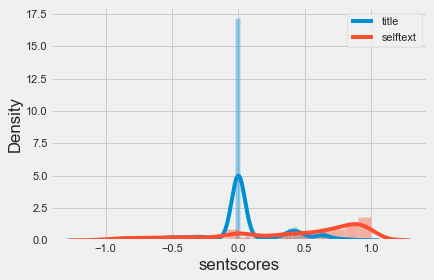

In [503]:
plt.style.use('fivethirtyeight')
sns.distplot(title_sentscores)
sns.distplot(selftext_sentscores)
plt.xlabel('sentscores')
plt.legend(['title', 'selftext'])

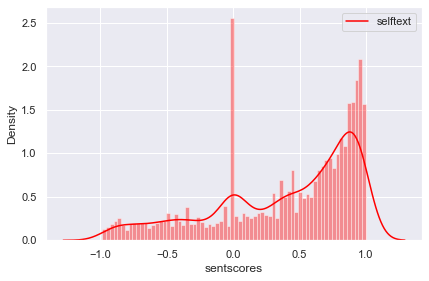

In [504]:
plt.style.use('fivethirtyeight')
sns.set_theme();
sns.distplot(selftext_sentscores, bins=70, kde =True, color='red')
plt.xlabel('sentscores')
plt.legend(['selftext'])

In [505]:
df.head()

,subreddit,selftext,title,selftext_word_count
1,cars,I personally Think Brooks From Dragtimes Track...,Who produces underrated Car content YouTube,24
3,cars,Im considering would love hear experience Heck...,Anyone direct experience selling car Bring Tra...,29
4,cars,I apologize rant I seriously need someone give...,Can former current car dealership mechanics te...,373
11,cars,Surely whichever car manufacturer makes one co...,Isnt market small efficient electric sports ca...,67
15,cars,What would good choice 17000 thats FWD sedan I...,What think Toyota,28


In [506]:
# Imports
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import time 

In [507]:
df = df.dropna() # drop any missing values 

In [508]:
# check the post counts

In [509]:
df['title_post_count'] = df['title'].map(lambda x: len(x))  # post count

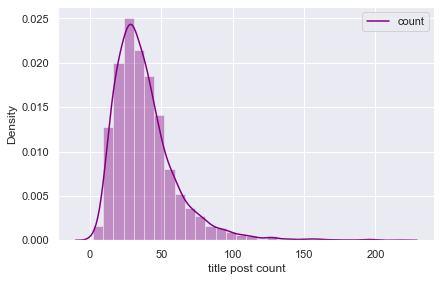

In [510]:
sns.set_theme();
sns.distplot(df['title_post_count'], bins=30, kde =True, color='purple')
plt.xlabel('title post count')
plt.legend(['count'])

Text(0.5, 1.0, 'Shortest tiltes')

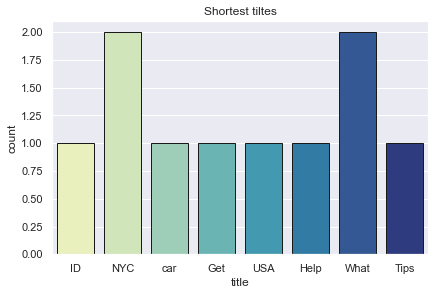

In [511]:
# show the 10 longest and shortest POSTs , not words
sns.countplot(df.sort_values(by ='title_post_count')['title'].head(10), ec='k', linewidth=1, palette='YlGnBu')
plt.xlabel('title')
plt.ylabel('count')
plt.title('Shortest tiltes')

Text(0.5, 1.0, 'Longest titles')

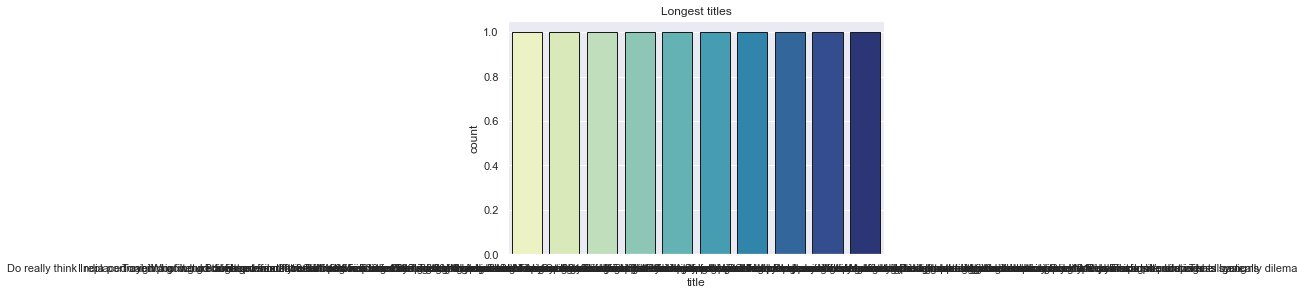

In [512]:
sns.countplot(df.sort_values(by ='title_post_count', ascending = False)['title'].head(10), ec='k', linewidth=1, palette='YlGnBu')
plt.xlabel('title')
plt.ylabel('count')
plt.title('Longest titles')

In [513]:
df.loc[15241, 'title'], df.loc[4568, 'title'], df.loc[5749, 'title'], df.loc[1797, 'title'], df.loc[5477, 'title']

('Do really think India portrayed pop culture films crowded streets cows holi noise real India Would interested knowing average upper middleclass Indian life skyscrapers Ubers truffle oil Dating apps etc like metro city',
 'I replaced cabin air filter microfilter wifes 2013 BMW 335i F30 today noted bottom heater blower yellow sticky stuff interior trim piece padding wet also yellowish area touched blower What would cause',
 'Tonight I going go drive get food I tried driving windshield kept fogging question When hot humid outside get condensation windshield temperature I put windshield defroster get condensation quickly',
 'What would take car manufacturers performance cars manual transmissions say Screw acceleration metrics going give car shorter gearing drivers actually row another gear without breaking speed limit',
 'Bought previously used rental vehicle 2017 Tuscon Hyundai SUV August 2018 I bought car I liked price however I opened car lingering odour I thought I could get rid I de

In [514]:
df.title[1797]

'What would take car manufacturers performance cars manual transmissions say Screw acceleration metrics going give car shorter gearing drivers actually row another gear without breaking speed limit'

In [515]:
df.selftext

1        I personally Think Brooks From Dragtimes Track...
3        Im considering would love hear experience Heck...
4        I apologize rant I seriously need someone give...
11       Surely whichever car manufacturer makes one co...
15       What would good choice 17000 thats FWD sedan I...
                               ...                        
19469    Im hoping travel Italy point future things eve...
19470    Iceland open fully vaccinated people US Ive it...
19478    The title vague I try explain detail I Lithuan...
19495    Hey guys July couple friends plan going Las Ve...
19499    Hi My 2 friends I late 20s looking place stay ...
Name: selftext, Length: 4859, dtype: object

In [516]:
df['selftext_post_count'] = df['selftext'].map(lambda x: len(x))

In [517]:
df['selftext_post_count']

1         116
3          90
4        1270
11        295
15        108
         ... 
19469     339
19470     133
19478     458
19495     327
19499     208
Name: selftext_post_count, Length: 4859, dtype: int64

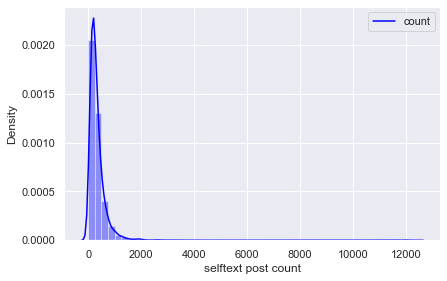

In [518]:
sns.set_theme();
sns.distplot(df['selftext_post_count'], bins=50, kde =True, color='blue')
plt.xlabel('selftext post count')
plt.legend(['count'])

In [519]:
import nltk, re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

In [520]:
# Regex for only english terms (with dots)
ENGLISH_RE = re.compile(r'[a-z]+')

In [521]:
df['title_token'] = df['title'].map(lambda x: word_tokenize(x))
df['selftext_token'] = df['selftext'].map(lambda x: word_tokenize(x))

In [522]:
print(df['title_token'])
print(df['selftext_token'])

1        [Who, produces, underrated, Car, content, YouT...
3        [Anyone, direct, experience, selling, car, Bri...
4        [Can, former, current, car, dealership, mechan...
11       [Isnt, market, small, efficient, electric, spo...
15                                   [What, think, Toyota]
                               ...                        
19469                          [Thoughts, Italian, Cities]
19470    [Does, anybody, good, recommendations, fjords,...
19478              [What, odds, able, travel, UK, wedding]
19495      [First, Time, Las, Vegas, Trip, With, My, Boys]
19499     [Key, West, USA, Accommodations, Recommendation]
Name: title_token, Length: 4859, dtype: object
1        [I, personally, Think, Brooks, From, Dragtimes...
3        [Im, considering, would, love, hear, experienc...
4        [I, apologize, rant, I, seriously, need, someo...
11       [Surely, whichever, car, manufacturer, makes, ...
15       [What, would, good, choice, 17000, thats, FWD,...
         

In [523]:
lmtzr = nltk.WordNetLemmatizer()

In [524]:
import itertools
title_merged_word = list(itertools.chain(*df['title_token']))
selftext_merged_word = list(itertools.chain(*df['selftext_token']))

In [525]:
title_word = [[lmtzr.lemmatize(word) for word in title_merged_word]]
selftext_word = [[lmtzr.lemmatize(word) for word in selftext_merged_word]]

In [526]:
title_word_list = list(itertools.chain(*title_word))
selftext_word_list = list(itertools.chain(*selftext_word))

In [527]:
# change to lower case for stop words removal
title_word_list = [x.lower() for x in title_word_list]

In [528]:
selftext_word_list = [x.lower() for x in selftext_word_list]

In [529]:
type(title_word_list)

list

In [530]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
title_words_list = [word for word in title_word_list if word not in stop]
selftext_words_list = [word for word in selftext_word_list if word not in stop]

In [531]:
# remove im, ive, dont from title_words_list and selftext_words_list
s = ['im', 'ive', 'dont']
title_words_list = [word for word in title_words_list if word not in s]
selftext_words_list = [word for word in selftext_words_list if word not in s]


In [532]:
print('++++++++++title word count++++++++++++')
fdist_title = nltk.FreqDist(title_words_list)
print(fdist_title.most_common(15))
print('++++++++++selftext word count++++++++++++')
fdist_selftext = nltk.FreqDist(selftext_words_list)
print(fdist_selftext.most_common(15))

++++++++++title word count++++++++++++
[('car', 845), ('travel', 305), ('trip', 219), ('help', 193), ('question', 183), ('best', 179), ('need', 169), ('anyone', 148), ('get', 146), ('us', 145), ('advice', 133), ('traveling', 126), ('day', 122), ('new', 119), ('looking', 106)]
++++++++++selftext word count++++++++++++
[('car', 4004), ('would', 2287), ('like', 1974), ('day', 1544), ('get', 1521), ('know', 1434), ('time', 1379), ('want', 1274), ('one', 1241), ('go', 1194), ('trip', 1048), ('travel', 961), ('also', 924), ('anyone', 913), ('need', 897)]


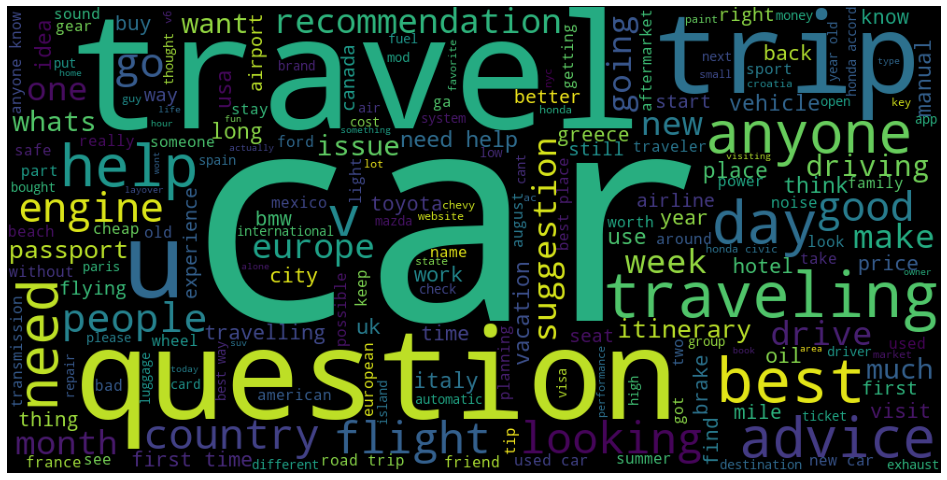

In [533]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join(title_words_list)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("title_words_list"+".png", bbox_inches='tight')
plt.show()

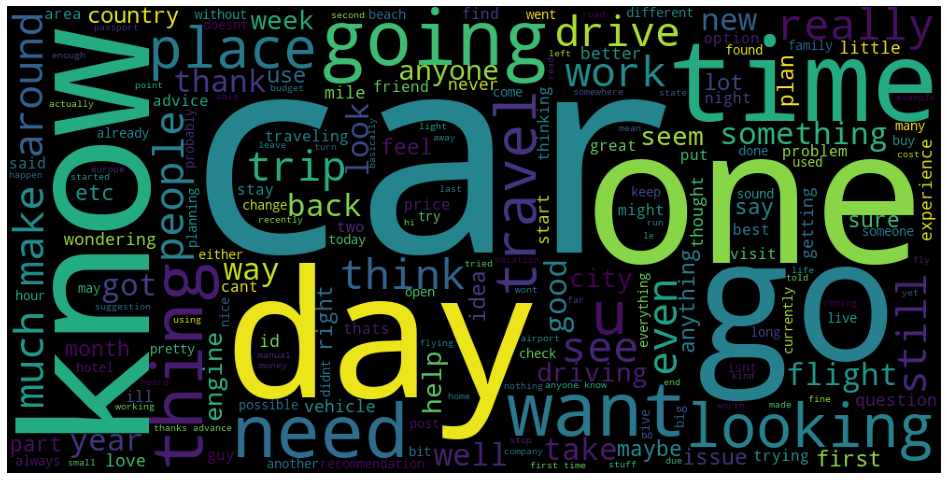

In [534]:
unique_string=(" ").join(selftext_words_list)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("selftext_words_list"+".png", bbox_inches='tight')
plt.show()

In [535]:
# Now using countvectorizer to deal with aboved stuff

In [536]:
df.columns

Index(['subreddit', 'selftext', 'title', 'selftext_word_count',
       'title_post_count', 'selftext_post_count', 'title_token',
       'selftext_token'],
      dtype='object')

In [537]:
df = df[['subreddit', 'selftext', 'title']]

In [538]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
import json

In [539]:
# combine X column to single one to do countvectorizer() - only take 1 column
df['fulltext'] = df['title'] + ' ' + df['selftext']

In [574]:
df.columns

Index(['subreddit', 'selftext', 'title', 'fulltext'], dtype='object')

In [577]:
X = df['fulltext']
y = df['subreddit']

In [541]:
X.sort_values()

367      02 Chevy Silverado 1500 rough time starting mo...
1467     02 sensor socket replacement 00 Civic I bought...
1923     06 Civic Woes Hello people So Im reaching Im p...
4003     07 v6 accord cv axle replacement problem I sna...
14042    1 2 countries In next year 2 planning go away ...
                               ...                        
14223    want add baggage tap airline dont know Hello e...
9325     water gear shift I 2006 hyundai sonata spilled...
477      weird squealing noise freeway 5th going around...
4014     whats car display page Im wondering model name...
2521     whats thing makes car good Dependability Luxur...
Name: fulltext, Length: 4859, dtype: object

In [542]:
# baseline model
y.value_counts(normalize=True)

cars      0.52233
travel    0.47767
Name: subreddit, dtype: float64

In [553]:
# split the data into the traininig and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

In [554]:
X_train

7726     P0340 05 Nissan 350Z replacing Camshaft positi...
6161     P2005 Code 2017 Ford Mustang GT Manual Transmi...
1642     2011 coupe honda accord 35L v6 good car good d...
8271     I 2016 Ford Fusion scraped underneath front bu...
7363     Can use 0W20 oil instead 5W20 I accidentally b...
                               ...                        
17017    Road trip Mexico Im American want explore Mexi...
11162    Day Trip Lysefjord Stavanger Kayak Ferry Hi I ...
17230    Is trip worth Mt Rushmore Hi everyone first ti...
5766     The Kia Rio shitbox I actually didnt hate Now ...
14479    Questions visiting Meteora Rhodes I trip Greec...
Name: fulltext, Length: 3401, dtype: object

In [545]:
#Xtrain_df = pd.DataFrame(X_train)

In [546]:
#logit.coef_[0]

In [547]:
#logit= LogisticRegression(penalty='none')

In [548]:
#logit.fit(X_train,y_train)

In [549]:
# fit_list = []
# for ib,j in zip(Xtrain_df.columns,lr.coef_[0]):
#     if j != 0:
#         fit_list.append([i,j])
# sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
# len(sorted_fit),sorted_fit[::-1]

In [550]:
# instantiate countvectorizer
# remove stopwords
from sklearn.feature_extraction import text 

my_words = ['im', 'ive', 'dont']
stop_words = text.ENGLISH_STOP_WORDS.union(my_words)
cvec = CountVectorizer(stop_words=stop_words)

In [551]:
# fit a transform the vectorizer
Xc_train = cvec.fit_transform(X_train)   # not sure if needs to be scaling up
Xc_test = cvec.transform(X_test)

In [552]:
feature_df = pd.DataFrame(Xc_train.todense(), columns = cvec.get_feature_names())

In [579]:
feature_df.columns

Index(['00', '000', '000lhslv525i', '000rhslv525i', '01', '0100', '01112018',
       '02', '020', '03',
       ...
       'zona', 'zone', 'zoo', 'zoom', 'zoomer', 'zoosafari', 'zr2', 'zr2s',
       'zurich', 'zurichstuttgarttubingen'],
      dtype='object', length=17382)

In [555]:
# 15 most common words
feature_df.sum().sort_values(ascending = False).head(10)

car       2701
like      1389
know      1011
want       899
time       893
travel     867
trip       805
cars       765
new        722
need       698
dtype: int64

In [558]:
#logit= LogisticRegression(penalty='none')

In [561]:
#logit.fit(Xc_train, y_train)

LogisticRegression(penalty='none')

In [565]:
#logit.coef_[0]

array([-0.21430907, -0.00448699,  0.00245608, ..., -0.09398947,
        0.03176093,  0.6249513 ])

In [566]:
# Xc_train_df = pd.DataFrame(Xc_train)

In [567]:
# fit_list = []
# for i,j in zip(Xc_train_df.columns,logit.coef_[0]):
#     if j != 0:
#         fit_list.append([i,j])
# sorted_fit = sorted(fit_list, key=lambda x:abs(x[1]))        
# len(sorted_fit),sorted_fit[::-1]

(1, [[0, -0.21430906965566127]])

In [568]:
fit_list

[[0, -0.21430906965566127]]

In [572]:
type(Xc_train_df.columns)

pandas.core.indexes.range.RangeIndex

# modeling

Naive Bayes and CountVectorization

In [ ]:
nb = MultinomialNB()

In [ ]:
# naive Bayes
pipe = Pipeline([
    ('cvec', CountVectorizer() ),
    ('nb', MultinomialNB())
])

In [ ]:
pipe_params = {
    'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.95, 0.9, 1],
    'cvec__ngram_range': [(1,1), (1,2)],
    
                }

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
# Instantiate GridsearchCV
grid = GridSearchCV(pipe,
                   pipe_params,
                   cv = kf)

In [ ]:
# Fit GridSearchCV to training data
grid.fit(X_train, y_train)   # think about why X_train, not Xs_train! 

In [ ]:
def model_evaluation(model):
    best_parameters= model.best_params_
    best_estimator = model.best_estimator_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    model_preds = model.predict(X_test)
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', display_labels = ['cars', 'travel']) 
    Accuracy = accuracy_score(y_test, model_preds)
    Recall = recall_score(y_test, model_preds,  pos_label='cars')
    Precision = precision_score(y_test, model_preds,  pos_label='cars')
    F1_score = f1_score(y_test, model_preds, pos_label='cars')
    ROC_AUC_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
#     model_preds_df = pd.DataFrame({'true_values': y_test,
#                         'preds_probs': model.predict_proba(X_test)[:,1]})
#     model_preds_df['true_values'] = model_preds_df['true_values'].map({'cars': 1, 'travel': 0})
   
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# for group in pd.DataFrame({'true_values': y_test,
#                         'preds_probs': model.predict_proba(X_test)[:,1]}).groupby('true_values'):
#     sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}',ax=axs[0,0])
# # # Add cutoff line at ~50% [default in sklearn]
# plt.axvline(0.5, color = 'black', linestyle = '--')
# plt.xlabel('Predicted Probability that Outcome = 1')
# plt.legend();

# ROC
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0,1], [0,1],label = 'baseline', linestyle = '--')
    plt.legend();
    return f'best parameters: {best_parameters}', f'best estimators: {best_estimator}', f'train score: {train_score}', f'test score: {test_score}', f'model predictions: {model_preds}', f'Accuracy: {Accuracy}', f'Sensitivity: {Recall}', f'Precision: {Precision}', f'F1 score: {F1_score}', f'AUC Score: {ROC_AUC_score}'

In [ ]:
model_evaluation(grid)

In [ ]:
#grid.best_params_

In [ ]:
#grid.best_estimator_

In [ ]:
#grid.score(X_train, y_train), grid.score(X_test, y_test)

In [ ]:
# prediction
#y_preds = grid.predict(X_test)

In [ ]:
#y_preds

In [ ]:
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# # Save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [ ]:
# # view confusion matrix
# plot_confusion_matrix(grid, X_test, y_test, cmap='Blues', display_labels = ['cars', 'travel'])

In [ ]:
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
# Accuracy = accuracy_score(y_test, y_preds)

In [ ]:
# Recall = recall_score(y_test, y_preds, pos_label='cars')

In [ ]:
# Recall

In [ ]:
# Precision = precision_score(y_test, y_preds, pos_label='cars')
# Precision

In [ ]:
# F1_score = f1_score(y_test, y_preds, pos_label='cars')
# F1_score

In [ ]:
# relationshiop between sensitvitiy and specificity 

In [ ]:
# preds_df = pd.DataFrame({'true_values': y_test,
#                         'preds_probs': grid.predict_proba(X_test)[:,1]})

In [ ]:
# preds_df['true_values'] = preds_df['true_values'].map({'cars': 1, 'travel': 0})

In [ ]:
# plt.figure(figsize = (12, 5))

# # plot distributions of predicted probabilities by actual values
# for group in preds_df.groupby('true_values'):
#     sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# # Add cutoff line at ~50% [default in sklearn]
# plt.axvline(0.5, color = 'black', linestyle = '--')

# plt.xlabel('Predicted Probability that Outcome = 1')
# plt.legend();

In [ ]:
# # ROC
# plot_roc_curve(grid, X_test, y_test)
# plt.plot([0,1], [0,1],
#     label = 'baseline', linestyle = '--')
# plt.legend()

In [ ]:
# The more area under this blue curve is, the better separated our distributions are.

In [ ]:
# # ROC AUC
# roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])
# # interpreation of AUC
# # since the AUC is 0.94, the postive and negative populations are separeated with little overlap

#LogisticRegression 

In [ ]:
from sklearn.linear_model import LogisticRegression
logit = Pipeline([
    ('cvec', CountVectorizer() ),
    ('logit', LogisticRegression(penalty='none',
               C = 1.0,
               solver='lbfgs',
               max_iter=1000,
               verbose=0))
])

In [ ]:
logit.fit(X_train, y_train)

In [580]:
    train_score = logit.score(X_train, y_train)
    test_score = logit.score(X_test, y_test)
    logit_preds = logit.predict(X_test)
    plot_confusion_matrix(logit, X_test, y_test, cmap='Blues', display_labels = ['cars', 'travel']) 
    Accuracy = accuracy_score(y_test, logit_preds)
    Recall = recall_score(y_test, logit_preds,  pos_label='cars')
    Precision = precision_score(y_test, logit_preds,  pos_label='cars')
    F1_score = f1_score(y_test, logit_preds, pos_label='cars')
    ROC_AUC_score = roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])
print(f'train score: {train_score}')
print(f'test score: {test_score}'), 
print(f'model predictions: {model_preds}')
print(f'Accuracy: {Accuracy}')
print(f'Sensitivity: {Recall}')
print(f'Precision: {Precision}')
print(f'F1 score: {F1_score}')
print(f'AUC Score: {ROC_AUC_score}')  

ValueError: could not convert string to float: 'P0340 05 Nissan 350Z replacing Camshaft position sensor fix car Like title says I 05 Nissan 350Z posts P0340 error code I replaced part code persists well check engine light TCSSLIP indicators The car starts power smells like running rich What else could causing P0340 Should I take POS'

Accuracy: 0.9801097393689986


#lasso logistic Regression

In [1238]:
from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform, loguniform
pipe = Pipeline([('cvec', CountVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
    )),
    ('ss', StandardScaler(with_mean=False)),
    ('lasso', LogisticRegression(penalty='l1',
                                 solver='liblinear'
                                 ))])

params = {
    'lasso__C': loguniform(1.0000001, 20)
}

In [1239]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
lasso = RandomizedSearchCV(pipe,
                            params,
                              n_iter=200,
                              cv=5,
                              n_jobs=-1,
                              verbose=True,
                              random_state=42)

lasso.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('ss',
                                              StandardScaler(with_mean=False)),
                                             ('lasso',
                                              LogisticRegression(penalty='l1',
                                                                 solver='liblinear'))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'lasso__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc047a35e80>},
           

("best parameters: {'lasso__C': 6.669254684490089}",
 "best estimators: Pipeline(steps=[('cvec',\n                 CountVectorizer(max_df=0.325, max_features=6500, min_df=5,\n                                 ngram_range=(1, 2),\n                                 stop_words=frozenset({'a', 'about', 'above',\n                                                       'across', 'after',\n                                                       'afterwards', 'again',\n                                                       'against', 'all',\n                                                       'almost', 'alone',\n                                                       'along', 'already',\n                                                       'also', 'although',\n                                                       'always', 'am', 'among',\n                                                       'amongst', 'amoungst',\n                                                       'amount', 'an', 'and',

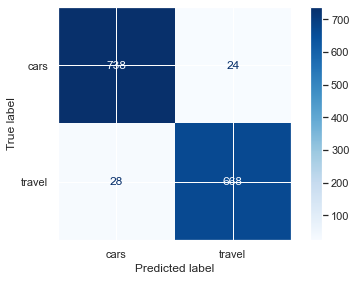

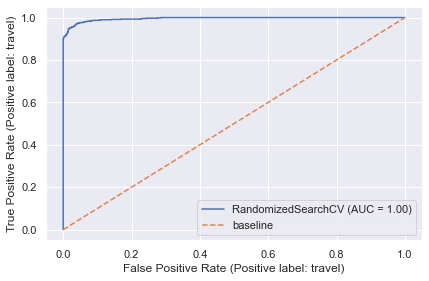

In [1234]:
model_evaluation(lasso)

#Ridge Logistic Regression

In [1240]:
pipe = Pipeline([('cvec', CountVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
   )),
    ('ss', StandardScaler(with_mean=False)),
    ('ridge', LogisticRegression(penalty='l2',
                                 solver='liblinear'
                                 ))])

ridge_params = {
    'ridge__C': loguniform(1.0000001, 20)
}

In [1241]:
ridge = RandomizedSearchCV(pipe,
                              ridge_params,
                              n_iter=75,
                              cv=5,
                              n_jobs=-1,
                              verbose=True,
                              random_state=42)

ridge.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('ss',
                                              StandardScaler(with_mean=False)),
                                             ('ridge',
                                              LogisticRegression(solver='liblinear'))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'ridge__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc0c2703f40>},
                   random_state=42, verbose=True)

("best parameters: {'ridge__C': 1.1085123587703856}",
 "best estimators: Pipeline(steps=[('cvec',\n                 CountVectorizer(max_df=0.325, max_features=6500, min_df=5,\n                                 ngram_range=(1, 2))),\n                ('ss', StandardScaler(with_mean=False)),\n                ('ridge',\n                 LogisticRegression(C=1.1085123587703856, solver='liblinear'))])",
 'train score: 1.0',
 'test score: 0.9595336076817559',
 "model predictions: ['cars' 'cars' 'cars' ... 'cars' 'cars' 'travel']",
 'Accuracy: 0.9595336076817559',
 'Sensitivity: 0.9671916010498688',
 'Precision: 0.9559014267185474',
 'F1 score: 0.9615133724722766',
 'AUC Score: 0.9914471897909314')

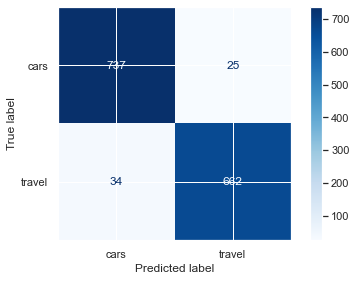

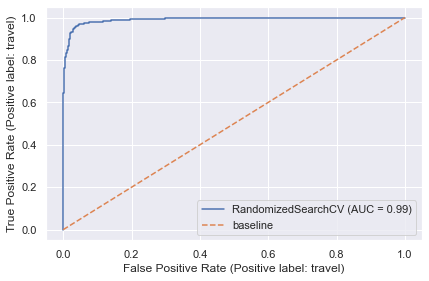

In [1242]:
model_evaluation(ridge)

# knn

In [1258]:
from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline([('cvec', CountVectorizer(
    max_df=.325,
    max_features=6500,
    min_df=5,
    ngram_range=(1, 2),
   )),
    ('knn', KNeighborsClassifier())])

knn_params = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}



In [1259]:
knn =  RandomizedSearchCV(
    pipe,
    knn_params,
    n_iter=75,
    n_jobs=-1,
    cv=5,
    verbose=0,
    random_state=42,
)

In [1260]:
knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(max_df=0.325,
                                                              max_features=6500,
                                                              min_df=5,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'knn__n_neighbors': [3, 5, 7],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=42)

'Accuracy: 0.6550068587105624'

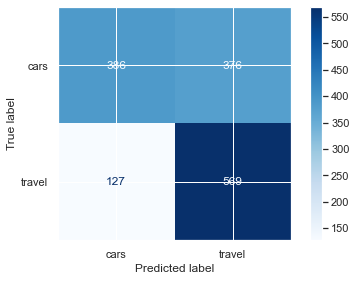

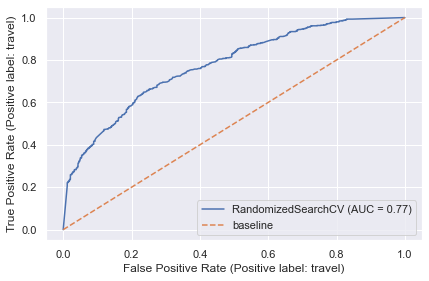

In [1266]:
model_evaluation(knn)[5]

In [1276]:
model_evaluation(logit)

AttributeError: 'Pipeline' object has no attribute 'best_params_'

Multinominal NaiveBayes:  Accuracy: 0.9849108367626886
Logistic Regression: 0.9801097393689986
Lasso Regression :  Accuracy: 0.9643347050754458
Ridge Regression:  Accuracy: 0.9595336076817559
KNN:  Accuracy: 0.6550068587105624


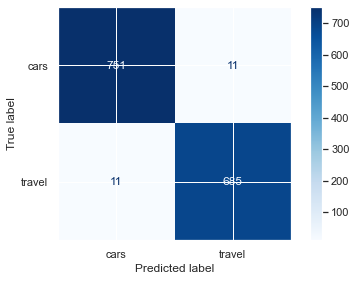

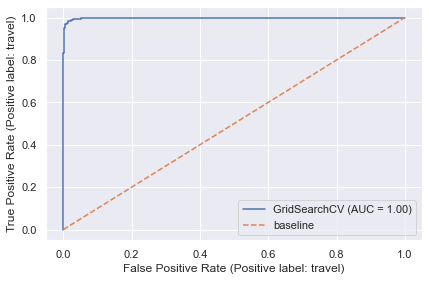

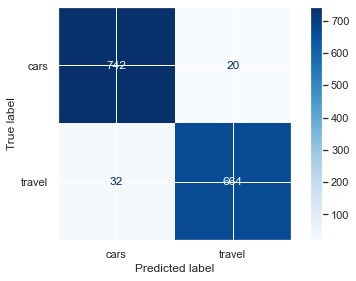

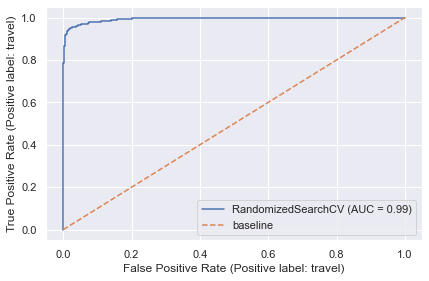

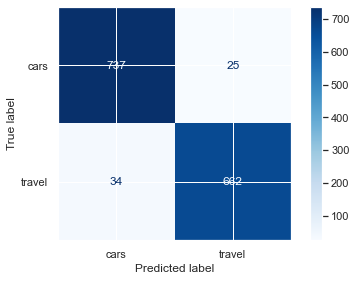

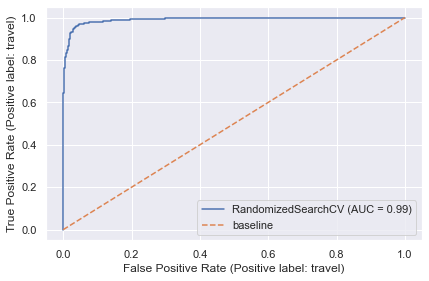

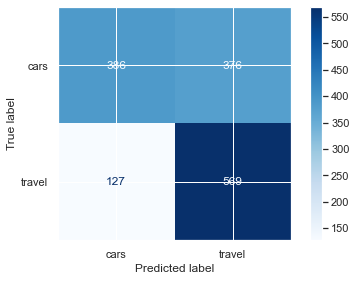

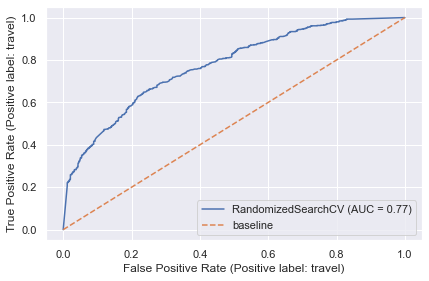

In [1280]:
print('Multinominal NaiveBayes: ', model_evaluation(grid)[5])
#print('Logistic Regression : ', model_evaluation(logit)[5])
print(f'Logistic Regression: {Accuracy}')
print('Lasso Regression : ', model_evaluation(lasso)[5])
print('Ridge Regression: ' , model_evaluation(ridge)[5])
print('KNN: ' , model_evaluation(knn)[5])